# Importing libraries

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras import metrics
from matplotlib import pyplot
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import random
from datetime import datetime
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
%matplotlib notebook
import tensorflow as tf
from tensorflow.python.client import device_lib

# Preparing Dataset

In [ ]:
!wget "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/hsr_misc_datasets.zip"

In [ ]:
!unzip "hsr_misc_datasets.zip"

Streaming output truncated to the last 5000 lines.
  inflating: with_RAW/ATT_Dataset/706/3.csv  
  inflating: with_RAW/ATT_Dataset/706/5.csv  
  inflating: with_RAW/ATT_Dataset/706/0.csv  
   creating: with_RAW/ATT_Dataset/1384/
  inflating: with_RAW/ATT_Dataset/1384/7.csv  
  inflating: with_RAW/ATT_Dataset/1384/4.csv  
  inflating: with_RAW/ATT_Dataset/1384/1.csv  
  inflating: with_RAW/ATT_Dataset/1384/2.csv  
  inflating: with_RAW/ATT_Dataset/1384/6.csv  
  inflating: with_RAW/ATT_Dataset/1384/3.csv  
  inflating: with_RAW/ATT_Dataset/1384/5.csv  
  inflating: with_RAW/ATT_Dataset/1384/0.csv  
   creating: with_RAW/ATT_Dataset/1131/
  inflating: with_RAW/ATT_Dataset/1131/4.csv  
  inflating: with_RAW/ATT_Dataset/1131/1.csv  
  inflating: with_RAW/ATT_Dataset/1131/2.csv  
  inflating: with_RAW/ATT_Dataset/1131/6.csv  
  inflating: with_RAW/ATT_Dataset/1131/3.csv  
  inflating: with_RAW/ATT_Dataset/1131/5.csv  
  inflating: with_RAW/ATT_Dataset/1131/0.csv  
   creating: with_RAW/ATT_

#  Loading Data with Timestamps

## Loading Data

In [ ]:
# Getting required stuff for time to prediction

# Methodology:
# Get end time of the current sequence
# Get the actual time of the handover
# Store handover time - end of curr sequence time as the earliest time for prediction
# Store this somewhere, along with a mapping for good evaluation
# Finally, evaluate to get the earliest time with good accuracy (maybe prune the dataset)
# Will likely need to change up how we make the dataset or alternatively add more data

dataset_master_folders = ["with_RAW/ATT_Dataset", "with_RAW/HSR_August_Dataset", "with_RAW/HSR_July_Dataset", "with_RAW/Sprint_Dataset", "with_RAW/Verizon_Dataset"]

# Helper function to convert strings into datetime objects
def string_to_datetime(timestamp_str):
    try:
        time_b = datetime.strptime(timestamp_str, "%Y-%m-%d %X.%f")
    except:
        time_b = datetime.strptime(timestamp_str, "%Y-%m-%d %X")
    return time_b


# This function extracts the rsrp, rsrq and labels, along with assigning the specific dataframe a "time to prediction"
def add_to_df_wts(filepath, window_size):
  df = pd.read_csv(filepath)
  df.drop(["Unnamed: 0"], axis=1, inplace=True)
  
  entries = []

  # Getting timestamp for handover (or at least as close to it as possible)
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime(last_entry_ts)

  if df.shape[0] >= window_size:
    for i in range(0, df.shape[0]-window_size):
      # Extracting the last timestamp for this window
      last_window_entry = df.iloc[i+window_size]
      last_window_ts = last_window_entry["timestamp"]
      lw_ts_dt = string_to_datetime(last_window_ts) # last window timestamp datetime object
      
      # Calculating time to handover and adding it to ttp
      tth = ho_ts_datetime - lw_ts_dt # time to handover
      tth_seconds = tth.total_seconds()

      # Extracting the rest
      temp = df.iloc[i:i+window_size]
      rsrp = temp["rsrp"]
      rsrq = temp["rsrq"]
      rsrp_raw = temp["rsrp_raw"]
      rsrq_raw = temp["rsrq_raw"]
      label = df.iloc[i]
      label = label["label"]

      entry = []
      entry.append(rsrp)
      entry.append(rsrq)
      entry.append(label)
      entry.append(tth_seconds)
      entry.append(rsrp_raw)
      entry.append(rsrq_raw)

      entries.append(entry)

    return entries

  return

sequence_dict = {}

WINDOW_SIZE = 5

ho_event_no = 0 # This counter keeps track of which handover event we have reached
for master_f in dataset_master_folders:
  dataset_folders = os.listdir(master_f)
  for folder in dataset_folders:
    folder_path = master_f + "/" + folder
    files = os.listdir(folder_path)
    ho_event_no += 1
    curr_hoevent_entries = [] # list containing all the data for the current handover event
    for f in files:
      filepath = folder_path + "/" + f
      entries = add_to_df_wts(filepath, WINDOW_SIZE)
      curr_hoevent_entries.append(entries)
    sequence_dict[ho_event_no] = curr_hoevent_entries

sequence_dict_orig = sequence_dict.copy()

## Generate Table


In [ ]:
# # Helper function to convert strings into datetime objects
# def string_to_datetime(timestamp_str):
#     try:
#         time_b = datetime.strptime(timestamp_str, "%Y-%m-%d %X.%f")
#     except:
#         time_b = datetime.strptime(timestamp_str, "%Y-%m-%d %X")
#     return time_b


# # This function extracts the rsrp, rsrq and labels, along with assigning the specific dataframe a "time to prediction"
# def add_to_df_wts(filepath, window_size):
#   df = pd.read_csv(filepath)
#   df.drop(["Unnamed: 0"], axis=1, inplace=True)
  
#   entries = []

#   # Getting timestamp for handover (or at least as close to it as possible)
#   last_entry = df.iloc[-1]
#   last_entry_ts = last_entry["timestamp"]
#   ho_ts_datetime = string_to_datetime(last_entry_ts)

#   if df.shape[0] >= window_size:
#     for i in range(0, df.shape[0]-window_size):
#       # Extracting the last timestamp for this window
#       last_window_entry = df.iloc[i+window_size]
#       last_window_ts = last_window_entry["timestamp"]
#       lw_ts_dt = string_to_datetime(last_window_ts) # last window timestamp datetime object
      
#       # Calculating time to handover and adding it to ttp
#       tth = ho_ts_datetime - lw_ts_dt # time to handover
#       tth_seconds = tth.total_seconds()

#       # Extracting the rest
#       temp = df.iloc[i:i+window_size]
#       rsrp = temp["rsrp"]
#       rsrq = temp["rsrq"]
#       rsrp_raw = temp["rsrp_raw"]
#       rsrq_raw = temp["rsrq_raw"]
#       label = df.iloc[i]
#       label = label["label"]

#       entry = []
#       entry.append(rsrp)
#       entry.append(rsrq)
#       entry.append(label)
#       entry.append(tth_seconds)
#       entry.append(rsrp_raw)
#       entry.append(rsrq_raw)

#       entries.append(entry)

#     return entries

#   return


# entries = add_to_df_wts("/content/with_RAW/HSR_July_Dataset/29/3.csv", 8)

In [ ]:
# scaler = MinMaxScaler(feature_range=(0,1))

# rsrp_list = []
# rsrq_list = []
# rsrp_raws_list = []
# rsrq_raws_list = []
# labels = []

# for entry in entries:
#   rsrp = np.array(entry[0])
#   rsrq = np.array(entry[1])
#   label = np.array(entry[2])
#   rsrp_raws = np.array(entry[4])
#   rsrq_raws = np.array(entry[5])
  
#   rsrp_list.append(rsrp)
#   rsrq_list.append(rsrq)
#   rsrp_raws_list.append(rsrp_raws)
#   rsrq_raws_list.append(rsrq_raws)
#   labels.append(label)

In [ ]:
# rsrp_tts = scaler.fit_transform(rsrp_list)
# rsrq_tts = scaler.fit_transform(rsrq_list)
# rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
# rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# # Combining features
# features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# # Generating labels
# labels = np.reshape(labels, (len(labels),1))

In [ ]:
# # Loading model
# # If you have modified the WINDOW_SIZE variable above, then load the correct model for the corresponding Window Size. You can find the models here:
# # https://anonymous.4open.science/r/EdgeCatBSPDataset-1840/README.md
# # Click on the model's file, and get the link from the "Download" button. 

# !wget "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/models/model_WS5.h5" -O "model.h5"

# model_eval = load_model("model.h5")

## Table part Over

In [ ]:
# Renaming the labels and converting into required data types

# sequence_dict = sequence_dict_orig.copy()

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  for i1, entry in enumerate(ho_event_list):
    if entry is not None:
      for i2, subentry in enumerate(entry):
        if subentry[2] == "not_target":
          sequence_dict[key][i1][i2][2] = 0
        else:
          sequence_dict[key][i1][i2][2] = 1

sequence_dict_renamed = sequence_dict.copy()

In [ ]:
# Function to detect if there are no "target" entries in here
def check_valid(sequence_dict, key):
  ho_event_list = sequence_dict[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sequence_dict[key][i][0][2]
      # print(sequence_dict[key][i][0][2])
      if label == 1:
        return True
  return False 

check_valid(sequence_dict, 1)

False

In [ ]:
sequence_dict = sequence_dict_orig.copy()

# Using minmax scaling to bring our features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

rsrp_list = []
rsrq_list = []
rsrp_raws_list = []
rsrq_raws_list = []
labels = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid(sequence_dict, key):
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = len(rsrp_list)
          rsrp = np.array(sequence_dict[key][i1][i2][0])
          rsrq = np.array(sequence_dict[key][i1][i2][1])
          label = np.array(sequence_dict[key][i1][i2][2])
          rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
          rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
          rsrp_list.append(rsrp)
          rsrq_list.append(rsrq)
          rsrp_raws_list.append(rsrp_raws)
          rsrq_raws_list.append(rsrq_raws)
          labels.append(label)
          sequence_dict[key][i1][i2][0] = req_idx
          sequence_dict[key][i1][i2][1] = req_idx
          sequence_dict[key][i1][i2][4] = req_idx
          sequence_dict[key][i1][i2][5] = req_idx
          # sequence_dict[key][i1][i2][2] = req_idx
        
rsrp_tts = scaler.fit_transform(rsrp_list)
rsrq_tts = scaler.fit_transform(rsrq_list)
rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# Combining features
features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# Reshaping label data
labels = np.reshape(labels, (len(labels),1))

This gives us a 1-1 mapping between event handover event and its data, along with indexable paths mapping the two, which we can use to evaluate the earliest time to prediction.

# Getting Time to Prediction Statistics for the last trained model

In [ ]:
# Loading model
# If you have modified the WINDOW_SIZE variable above, then load the correct model for the corresponding Window Size. You can find the models here:
# https://anonymous.4open.science/r/EdgeCatBSPDataset-1840/README.md
# Click on the model's file, and get the link from the "Download" button. 

!wget "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/models/model_WS5.h5" -O "model.h5"

model_eval = load_model("model.h5")

In [ ]:
# TODO:
# Traverse through each "Handover event"
# Apply filter so that only the lists that contain at least one actual handover are extracted
# Further need 2 statistics: time to prediction, and the total number of base stations predicted as "true"
with tf.device('/device:GPU:0'):
  predictions_orig = model_eval.predict(features)
  predictions = (predictions_orig > 0.37)
cm = confusion_matrix(labels, predictions)
tn, fp, fn, tp = cm.ravel()

print("True Negative: ", tn)
print("False Positive: ", fp)
print("False Negative: ", fn)
print("True Positive: ", tp)
print(cm)

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1_score = 2*precision*recall/(precision+recall)
print(f1_score)


420/420 [==============================] - 2s 3ms/step
True Negative:  3284
False Positive:  5519
False Negative:  146
True Positive:  4483
[[3284 5519]
 [ 146 4483]]
0.6128084204770692


In [ ]:
def check_valid_2(sd, key):
  ho_event_list = sd[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sequence_dict[key][i][0][2]
      if label == 1:
        return True
  return False 

# Required statistics: %age of handover events where a correct prediction is made
# Storing the earliest time to prediction
# Total number of base stations predicted as true

earliest_times = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    # We are now in the measurements for the current entry
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:

        for i2, subentry in enumerate(entry):
          req_idx = sequence_dict[key][i1][i2][0]
          label = labels[req_idx][0]
          if label == 1:
            # this subentry doesnt have the required entry for time to prediction
            # break
            prediction = predictions[req_idx]
            if prediction == 1:
              # print(sequence_dict[key][i1][i2][3])
              earliest_times.append(sequence_dict[key][i1][i2][3])
              break
        

In [ ]:
# Conflict Resolution Implementation

# Dictionary to contain the prediction values for correct and false target predictions
predictions_per_ho = []

time_idx = 0

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    # Now looking at the current handover event
    
    per_timestamp_dict = {}

    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        # Making 2 dictionaries, one for the earliest correct prediction, and the other for all incorrect predictions        

        for i2, subentry in enumerate(entry):
          req_idx = sequence_dict[key][i1][i2][0]
          label = labels[req_idx][0]
          if label == 1:
            # Label for true prediction
            prediction = predictions[req_idx]
            if prediction == 1:
              # True positive case
              # print(sequence_dict[key][i1][i2][3])
              # earliest_times.append(sequence_dict[key][i1][i2][3])
              time_idx = sequence_dict[key][i1][i2][3]
              
              try: 
                per_timestamp_dict[time_idx]
                per_timestamp_dict[time_idx]["correct"] = predictions_orig[req_idx]
              except:
                per_timestamp_dict[time_idx] = {}
                per_timestamp_dict[time_idx]["correct"] = predictions_orig[req_idx]
                
          if label == 0:
            prediction = predictions[req_idx]
            
            if prediction == 1:
              # False negative case

              try:
                per_timestamp_dict[time_idx]
              except:
                per_timestamp_dict[time_idx] = {}
              
              try:
                per_timestamp_dict[time_idx]["incorrect"]
                per_timestamp_dict[time_idx]["incorrect"].append(predictions_orig[req_idx])
              except:
                per_timestamp_dict[time_idx]["incorrect"] = [predictions_orig[req_idx]]


              # if per_timestamp_dict[time_idx] is None:
              #   per_timestamp_dict[time_idx] = {}
              #   if per_timestamp_dict[time_idx]["incorrect"] is None:
              #     per_timestamp_dict[time_idx]["incorrect"] = [predictions_orig[req_idx]]
              #   else:
              #     per_timestamp_dict[time_idx]["incorrect"].append(predictions_orig[req_idx])

    predictions_per_ho.append(per_timestamp_dict)    
              


In [ ]:
fp_total = 0

for i, prediction_dict in enumerate(predictions_per_ho):
  for key in prediction_dict.keys():
    current_entry = prediction_dict[key]
    try:
      current_entry["incorrect"]

      fp_total += len(current_entry["incorrect"])
    except:
      pass

print("False positives total:", fp_total)

fp_avoidable = 0

for i, prediction_dict in enumerate(predictions_per_ho):
  for key in prediction_dict.keys():
    current_entry = prediction_dict[key]
    try:
      current_entry["incorrect"]
      current_entry["correct"]

      fp_avoidable += len(current_entry["incorrect"])
    except:
      pass

print("Avoidable false positives:", fp_avoidable)

fp_removed = 0

new_fps = 0
tps_gone = 0


for i, prediction_dict in enumerate(predictions_per_ho):
  for key in prediction_dict.keys():
    current_entry = prediction_dict[key]
    try:
      current_entry["incorrect"]
      current_entry["correct"]
      
      correct_confidence = current_entry["correct"]
      incorrect_confidences = current_entry["incorrect"]

      # print("Correct confidence:", correct_confidence[0])
      mispredict = False

      for conf in incorrect_confidences:
        if conf[0] < correct_confidence:
          fp_removed += 1
        else:
          # print("Difference: ", conf[0] - correct_confidence)
          # if (conf[0] - correct_confidence) > 0.1:
          # new_fps += 1
          mispredict = True

      if mispredict:
        tps_gone += 1

    except:
      pass

print("False positives removed: ", fp_removed)

print("Percentage of false positives removed out of total: ", fp_removed/fp_total * 100)
print("Percentage of false positives removed out of avoidable total: ", fp_removed/fp_avoidable * 100)

print("Number of True Positives lost to misprediction:", tps_gone)

False positives total: 2051
Avoidable false positives: 2017
False positives removed:  1748
Percentage of false positives removed out of total:  85.22671867381764
Percentage of false positives removed out of avoidable total:  86.66336142786317
Number of True Positives lost to misprediction: 30


True Positives: 2582
False Positives: 2051
False Negatives: 156
True Negatives: 2402
0.9125692830323621


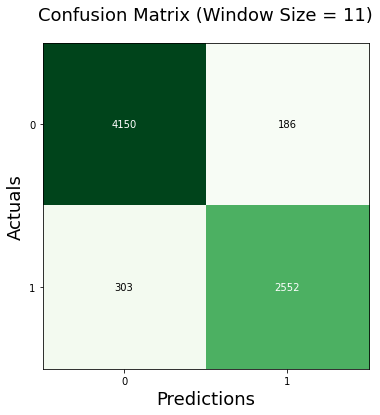

In [ ]:
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Negatives:", tn)

# Updates made after the introduction of 
new_fp = fp - fp_removed
new_tp = tp - tps_gone
new_tn = tn + fp_removed
new_fn = fn + tps_gone
cm = np.array([[new_tn, new_fn], [new_fp ,new_tp]])

precision = new_tp/(new_tp+new_fp)
recall = new_tp/(new_tp+new_fn)

f1_score = 2*precision*recall/(precision+recall)
print(f1_score)

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (Window Size = ' + str(WINDOW_SIZE) + ')', fontsize=18)
plt.show()

In [ ]:
# counting the number of handover events that have something to be predicted
count = 0
for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    count += 1

total_ho_count = count
print(count)

218


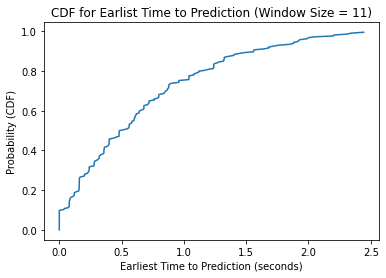

                0
count  214.000000
mean     0.649858
std      0.583469
min      0.000000
25%      0.160953
50%      0.481094
75%      0.959475
max      2.442865


In [ ]:
# print(len(earliest_times))
%matplotlib inline
# Declare num of datapoints
N = len(earliest_times)

x = np.sort(earliest_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Earlist Time to Prediction (Window Size = " + str(WINDOW_SIZE) + ")")

plt.plot(x,y, marker='')
plt.show()

earliest_times_df = pd.DataFrame(earliest_times)
print(earliest_times_df.describe())

In [ ]:
OUTPUTFILEPATH = "" # Modify this variable depending on where you want to save results
filename = OUTPUTFILEPATH + str(WINDOW_SIZE) + 'CDF.txt'
file = open(filename,'w')
for t in earliest_times:
	file.write(str(t)+"\n")
file.close()

In [ ]:
# Calculating #age of events missed by the algorithm
num_predicted = len(earliest_times_df)
percentage_missed = (total_ho_count - num_predicted) / total_ho_count * 100
print("Percentage of handover events for which predictions could not be made:", percentage_missed)

Percentage of handover events for which predictions could not be made: 1.834862385321101


# Evaluation Performance on different datasets

In [ ]:
HSR_datasets = ["with_RAW/HSR_August_Dataset", "with_RAW/HSR_July_Dataset"]
Misc_datasets = ["with_RAW/ATT_Dataset", "with_RAW/Sprint_Dataset", "with_RAW/Verizon_Dataset"]

WINDOW_SIZE = 5

# Loading model
# If you have modified the WINDOW_SIZE variable above, then load the correct model for the corresponding Window Size. You can find the models here:
# https://anonymous.4open.science/r/EdgeCatBSPDataset-1840/README.md
# Click on the model's file, and get the link from the "Download" button. 

!wget "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/models/model_WS5.h5" -O "model.h5"

model_eval = load_model("model.h5")

window_size = WINDOW_SIZE

In [ ]:
# Complete pipeline for HSR

sequence_dict = {}

ho_event_no = 0 # This counter keeps track of which handover event we have reached
for master_f in HSR_datasets:
  dataset_folders = os.listdir(master_f)
  for folder in dataset_folders:
    folder_path = master_f + "/" + folder
    files = os.listdir(folder_path)
    ho_event_no += 1
    curr_hoevent_entries = [] # list containing all the data for the current handover event
    for f in files:
      filepath = folder_path + "/" + f
      entries = add_to_df_wts(filepath, window_size)
      curr_hoevent_entries.append(entries)
    sequence_dict[ho_event_no] = curr_hoevent_entries

sequence_dict_orig = sequence_dict.copy()

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  for i1, entry in enumerate(ho_event_list):
    if entry is not None:
      for i2, subentry in enumerate(entry):
        if subentry[2] == "not_target":
          sequence_dict[key][i1][i2][2] = 0
        else:
          sequence_dict[key][i1][i2][2] = 1

sequence_dict_renamed = sequence_dict.copy()

sequence_dict = sequence_dict_orig.copy()

# Using minmax scaling to bring our features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

rsrp_list = []
rsrq_list = []
rsrp_raws_list = []
rsrq_raws_list = []
labels = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid(sequence_dict, key):
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = len(rsrp_list)
          rsrp = np.array(sequence_dict[key][i1][i2][0])
          rsrq = np.array(sequence_dict[key][i1][i2][1])
          label = np.array(sequence_dict[key][i1][i2][2])
          rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
          rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
          rsrp_list.append(rsrp)
          rsrq_list.append(rsrq)
          rsrp_raws_list.append(rsrp_raws)
          rsrq_raws_list.append(rsrq_raws)
          labels.append(label)
          sequence_dict[key][i1][i2][0] = req_idx
          sequence_dict[key][i1][i2][1] = req_idx
          sequence_dict[key][i1][i2][4] = req_idx
          sequence_dict[key][i1][i2][5] = req_idx
          # sequence_dict[key][i1][i2][2] = req_idx
        
rsrp_tts = scaler.fit_transform(rsrp_list)
rsrq_tts = scaler.fit_transform(rsrq_list)
rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# Combining features
HSR_features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# Reshaping label data
HSR_labels = np.reshape(labels, (len(labels),1))

212/212 [==============================] - 2s 4ms/step


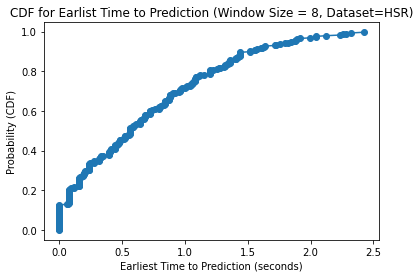

                0
count  286.000000
mean     0.678480
std      0.587772
min      0.000000
25%      0.160009
50%      0.560233
75%      1.076682
max      2.422982


In [ ]:
predictions = model_eval.predict(HSR_features)
HSR_predictions = (predictions > 0.37)
cm = confusion_matrix(HSR_labels, HSR_predictions)
tn, fp, fn, tp = cm.ravel()

earliest_times = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    # We are now in the measurements for the current entry
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = sequence_dict[key][i1][i2][0]
          label = HSR_labels[req_idx][0]
          if label == 1:
            # this subentry doesnt have the required entry for time to prediction
            # break
            prediction = HSR_predictions[req_idx]
            if prediction == 1:
              # print(sequence_dict[key][i1][i2][3])
              earliest_times.append(sequence_dict[key][i1][i2][3])
              break

%matplotlib inline
# Declare num of datapoints
N = len(earliest_times)

x = np.sort(earliest_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Earlist Time to Prediction (Window Size = 5, Dataset=HSR)")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(earliest_times)
print(earliest_times_df.describe())

In [ ]:
# write the data in x and y to a text file
# print(earliest_times)
# file = open('WS5_HSR_earliest_times.txt','w')
# for t in earliest_times:
# 	file.write(str(t)+"\n")
# file.close()

[1.310058, 1.795018, 2.258668, 1.080742, 0.239999, 1.914267, 0.16, 1.604349, 1.998934, 0.561864, 0.87584, 0.674721, 0.0, 1.843185, 0.587869, 0.0, 0.722134, 0.441063, 1.089241, 1.150016, 0.482124, 0.0, 0.0, 1.880263, 1.517139, 0.0, 0.721613, 0.810805, 1.359994, 0.396818, 0.524075, 0.0, 0.240003, 0.479996, 0.086066, 1.079982, 2.326061, 0.160978, 2.122168, 0.0, 0.080005, 0.079998, 0.0, 0.319997, 0.522126, 0.280015, 0.563994, 0.238935, 1.422873, 1.039999, 0.160016, 1.519994, 0.561869, 0.836089, 0.719946, 0.559998, 0.119706, 0.842112, 1.198953, 0.15999, 0.28, 1.119994, 1.065002, 0.836089, 1.882097, 0.674721, 0.51787, 1.066784, 0.0, 0.478928, 0.582873, 0.0, 1.360007, 0.191068, 0.919106, 0.0, 0.406065, 0.238935, 0.560468, 0.522126, 1.318198, 0.080055, 0.871804, 0.412008, 1.318198, 0.881059, 0.239998, 0.079999, 1.200097, 1.339982, 1.555131, 0.406065, 0.12, 0.603844, 0.4779, 1.714999, 0.956807, 0.0, 0.08, 1.081944, 0.313939, 0.331628, 0.810805, 0.842112, 0.795953, 0.480054, 0.160004, 0.279995, 

In [ ]:
g100 = 0
g200 = 0
g500 = 0
g1000 = 0

for x in earliest_times:
  if x >= 0.1:
    g100 += 1
  if x >= 0.2:
    g200 += 1
  if x >= 0.5:
    g500 += 1
  if x >= 1:
    g1000 += 1

print("100: ", g100/N * 100)
print("200: ", g200/N * 100)
print("500: ", g500/N * 100)
print("1000: ", g1000/N * 100)

100:  78.67132867132867
200:  70.97902097902097
500:  54.1958041958042
1000:  28.321678321678323


In [ ]:
################## Evaluating for misc dataset now #############################

In [ ]:
# Complete pipeline for Misc

sequence_dict = {}

ho_event_no = 0 # This counter keeps track of which handover event we have reached
for master_f in Misc_datasets:
  dataset_folders = os.listdir(master_f)
  for folder in dataset_folders:
    folder_path = master_f + "/" + folder
    files = os.listdir(folder_path)
    ho_event_no += 1
    curr_hoevent_entries = [] # list containing all the data for the current handover event
    for f in files:
      filepath = folder_path + "/" + f
      entries = add_to_df_wts(filepath, window_size)
      curr_hoevent_entries.append(entries)
    sequence_dict[ho_event_no] = curr_hoevent_entries

sequence_dict_orig = sequence_dict.copy()

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  for i1, entry in enumerate(ho_event_list):
    if entry is not None:
      for i2, subentry in enumerate(entry):
        if subentry[2] == "not_target":
          sequence_dict[key][i1][i2][2] = 0
        else:
          sequence_dict[key][i1][i2][2] = 1

sequence_dict_renamed = sequence_dict.copy()

sequence_dict = sequence_dict_orig.copy()

# Using minmax scaling to bring our features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

rsrp_list = []
rsrq_list = []
rsrp_raws_list = []
rsrq_raws_list = []
labels = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid(sequence_dict, key):
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = len(rsrp_list)
          rsrp = np.array(sequence_dict[key][i1][i2][0])
          rsrq = np.array(sequence_dict[key][i1][i2][1])
          label = np.array(sequence_dict[key][i1][i2][2])
          rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
          rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
          rsrp_list.append(rsrp)
          rsrq_list.append(rsrq)
          rsrp_raws_list.append(rsrp_raws)
          rsrq_raws_list.append(rsrq_raws)
          labels.append(label)
          sequence_dict[key][i1][i2][0] = req_idx
          sequence_dict[key][i1][i2][1] = req_idx
          sequence_dict[key][i1][i2][4] = req_idx
          sequence_dict[key][i1][i2][5] = req_idx
          # sequence_dict[key][i1][i2][2] = req_idx
        
rsrp_tts = scaler.fit_transform(rsrp_list)
rsrq_tts = scaler.fit_transform(rsrq_list)
rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# Combining features
Misc_features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# Reshaping label data
Misc_labels = np.reshape(labels, (len(labels),1))

208/208 [==============================] - 1s 3ms/step


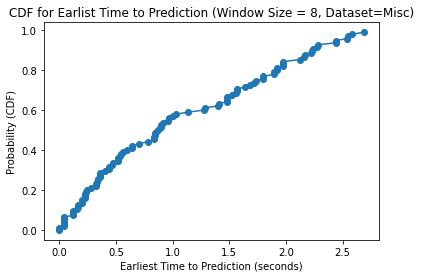

               0
count  95.000000
mean    1.045631
std     0.797511
min     0.000000
25%     0.338548
50%     0.858226
75%     1.729209
max     2.686103


In [ ]:
predictions = model_eval.predict(Misc_features)
Misc_predictions = (predictions > 0.37)
cm = confusion_matrix(Misc_labels, Misc_predictions)
tn, fp, fn, tp = cm.ravel()

earliest_times = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    # We are now in the measurements for the current entry
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = sequence_dict[key][i1][i2][0]
          label = Misc_labels[req_idx][0]
          if label == 1:
            # this subentry doesnt have the required entry for time to prediction
            # break
            prediction = Misc_predictions[req_idx]
            if prediction == 1:
              # print(sequence_dict[key][i1][i2][3])
              earliest_times.append(sequence_dict[key][i1][i2][3])
              break

%matplotlib inline
# Declare num of datapoints
N = len(earliest_times)

x = np.sort(earliest_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Earlist Time to Prediction (Window Size = 8, Dataset=Misc)")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(earliest_times)
print(earliest_times_df.describe())

In [ ]:
# print(earliest_times)
# file = open('WS5_Misc_earliest_times.txt','w')
# for t in earliest_times:
# 	file.write(str(t)+"\n")
# file.close()

[0.0, 2.437869, 0.16, 0.039984, 0.16125, 0.345, 0.545034, 0.959239, 0.999981, 0.039966, 0.22291, 0.22291, 1.898945, 0.119999, 0.858226, 1.026067, 1.408146, 0.359999, 0.22291, 0.893941, 0.839931, 1.738948, 1.799971, 0.847163, 1.898945, 0.240146, 2.159996, 0.839931, 0.039528, 0.475055, 0.2, 1.13779, 1.799971, 0.120407, 2.580778, 0.0, 0.239999, 0.120407, 0.280228, 1.400019, 0.847163, 2.172221, 1.971072, 2.550023, 2.228259, 0.332096, 1.640745, 0.407177, 2.221248, 0.894946, 0.465337, 1.971072, 0.785031, 2.443176, 1.559297, 2.243177, 0.199985, 0.320018, 0.59793, 1.564314, 2.538191, 2.275015, 1.683951, 1.521018, 0.439989, 2.120043, 0.638383, 1.27606, 0.357944, 0.881793, 0.327158, 0.963961, 0.162089, 0.439989, 0.360024, 1.479071, 1.475862, 1.479071, 0.038949, 1.564314, 0.559981, 0.519993, 0.637953, 1.282063, 0.535976, 1.71947, 0.521922, 1.919924, 0.038949, 0.70395, 2.281827, 1.972123, 0.918211, 1.917717, 2.686103]


In [ ]:
# print(earliest_times)

# earliest_times_conv = np.array(earliest_times)
# earliest_times_conv = np.reshape(earliest_times_conv, (len(earliest_times_conv),1))

# greater_than_1000 = (earliest_times_conv > 1)
# print(len(greater_than_1000)/N * 100)

g100 = 0
g200 = 0
g500 = 0
g1000 = 0

for x in earliest_times:
  if x >= 0.1:
    g100 += 1
  if x >= 0.2:
    g200 += 1
  if x >= 0.5:
    g500 += 1
  if x >= 1:
    g1000 += 1

print("100: ", g100/N * 100)
print("200: ", g200/N * 100)
print("500: ", g500/N * 100)
print("1000: ", g1000/N * 100)


100:  92.63157894736842
200:  85.26315789473684
500:  65.26315789473685
1000:  42.10526315789473
